In [1]:
import pickle as pkl
from simulator.rl_wrapper import CentralizedAggregatedSim, DecentralizedAggregatedSim
from simulator.fast_simulator import FastSimulator
from simulator.simulator import Simulator
import matplotlib
import matplotlib.pyplot as plt
import torch
from simulator.rl import RL, ActionSpace
import pandas as pd
import numpy as np
import seaborn as sns

action_space = ActionSpace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_folder = "saved_models"

In [2]:
online_test = True

In [3]:
# change of population in a day

In [4]:
fsim = FastSimulator(interval = 30, suffix='quicktest1')
rsts = fsim.rsts
pops = []
pops_cummulative = []
times = []
t = 10
for rst in rsts:
    t += fsim.interval / 60
    times.append(t)
    pops.append(rst.iloc[:, 1:-2].sum(axis=0))
    pops_cummulative.append(rst.iloc[:, 1:-2].sum().sum())

df = pd.DataFrame(pops)
df.index = times
df.insert(0, 'Total Population', pops_cummulative)

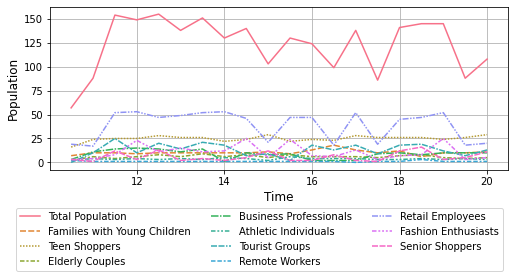

In [5]:
plt.figure(figsize=(8.2, 3))
ax = sns.lineplot(data=df, linewidth=1.5)
plt.legend(fontsize=12)
sns.move_legend(ax, "lower right", bbox_to_anchor=(1, -0.65), ncol=3)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Population', fontsize=12)
plt.grid()

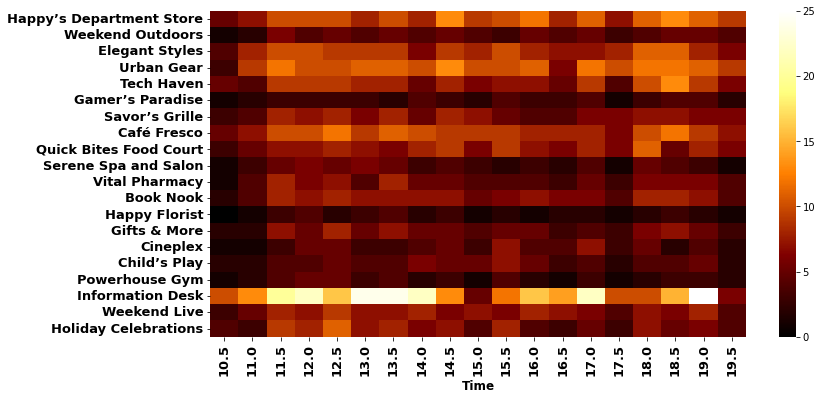

In [6]:
fsim = FastSimulator(interval=30, suffix='quicktest1')
pops = []
time = 10
for df in fsim.rsts:
    time += 0.5
    pops.append(df.set_index('Store').iloc[:,:-2].sum(axis=1).to_dict() | {'time': time})
store_pops_df = pd.DataFrame(pops).set_index('time')

plt.figure(figsize=(12, 6))
sns.heatmap(store_pops_df.iloc[:-1, :].T, annot=False, cmap="afmhot", fmt=".0f")
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold', rotation=90)
plt.show()

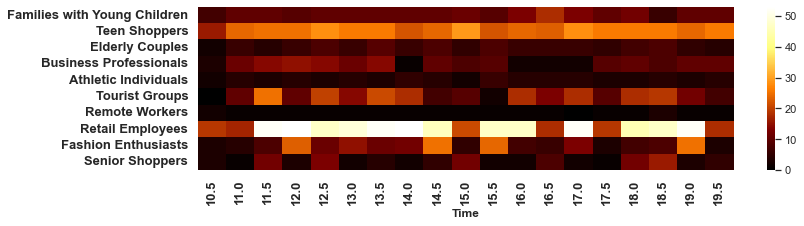

In [7]:
rl_model = pkl.load(open(f"{path_folder}/centralized_control_ori_model.pkl", "rb"))

sim = CentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))

sim.step()
temp_contorls = []
recorded_states = []
actions = []
for i in range(19):
    state = sim.get_states()
    recorded_states.append(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = rl_model.predict(state)
    rl_temp = action_space.convert(action.item())
    actions.append(rl_temp)
    temp_contorls.append(rl_temp)
    sim.apply_action(rl_temp)
    sim.step()

recorded_states = np.array(recorded_states)[:, :-3]
recorded_pops, times = recorded_states[:, :-2].T, recorded_states[:, -1]
df = pd.DataFrame(recorded_pops, columns=times)
pop_types = sim.rst_df.columns.tolist()[1:-2]
df.index = pop_types

sns.set(rc={'figure.figsize':(12, 3)})
sns.heatmap(df, annot=False, cmap="afmhot", fmt=".0f")
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold', rotation=90)
plt.show()


In [8]:
# convergence plot

In [9]:
centralized_convergence_plots = {}
decentralized_convergence_plots = {}
for type in ["ori", "alpha0", "beta0"]:
    centralized_convergence_plots[type] = pkl.load(open(f"{path_folder}/centralized_control_{type}_convergence_plot.pkl", "rb"))
    decentralized_convergence_plots[type] = pkl.load(open(f"{path_folder}/decentralized_control_{type}_convergence_plot.pkl", "rb"))

In [10]:
sns.reset_orig()

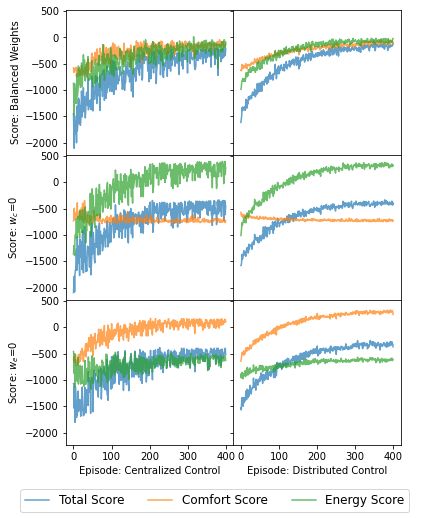

In [11]:
name_map = {'ori': 'Score: Balanced Weights', 'alpha0': r'Score: $w_{c}$=0', 'beta0': r'Score: $w_{e}$=0'}

fig, axes = plt.subplots(3, 2, figsize=(6, 8), sharex=True, sharey=True)
for i in range(2):
    for j, type in enumerate(["ori", "alpha0", "beta0"]):
        if i == 0:
            plot_data = np.array(centralized_convergence_plots[type])
            title = f"Centralized {type}"
            xlabel = "Episode: Centralized Control"
        elif i == 1:
            plot_data = np.array(decentralized_convergence_plots[type])
            title = f"Decentralized {type}"
            xlabel = "Episode: Distributed Control"
        
        axes[j, i].plot(plot_data[:, 0], alpha=0.7, label='Total Score')
        axes[j, i].plot(plot_data[:, 1], alpha=0.7, label='Comfort Score')
        axes[j, i].plot(plot_data[:, 2], alpha=0.7, label='Energy Score')
        axes[j, 0].set_ylabel(name_map[type])
        axes[2, i].set_xlabel(xlabel)

fig.subplots_adjust(hspace=0, wspace=0)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=12)
plt.show()


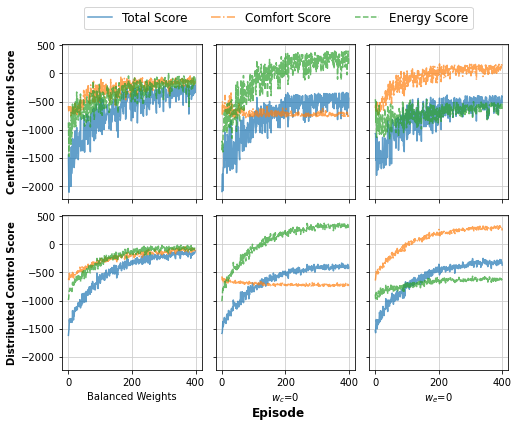

In [12]:
name_map = {'ori': 'Balanced Weights', 'alpha0': r'$w_{c}$=0', 'beta0': r'$w_{e}$=0'}

fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True, sharey=True)
for i in range(2):
    for j, type in enumerate(["ori", "alpha0", "beta0"]):
        if i == 0:
            plot_data = np.array(centralized_convergence_plots[type])
            #title = f"Centralized {type}"
            ylabel = "Centralized Control Score"
        elif i == 1:
            plot_data = np.array(decentralized_convergence_plots[type])
            #title = f"Decentralized {type}"
            ylabel = "Distributed Control Score"
        
        # update the markers
        axes[i, j].plot(plot_data[:, 0], "-", alpha=0.7, label='Total Score')
        axes[i, j].plot(plot_data[:, 1], "-.", alpha=0.7, label='Comfort Score')
        axes[i, j].plot(plot_data[:, 2], "--", alpha=0.7, label='Energy Score')
        axes[i, j].grid(color='0.8')
        axes[i, 0].set_ylabel(ylabel, fontweight='bold')
        axes[1, j].set_xlabel(name_map[type])


fig.subplots_adjust(hspace=0.1, wspace=0.1)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.supxlabel('Episode', fontsize=12, fontweight='bold')
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, 0.98))
fig.savefig('training.png', dpi=500)
plt.show()



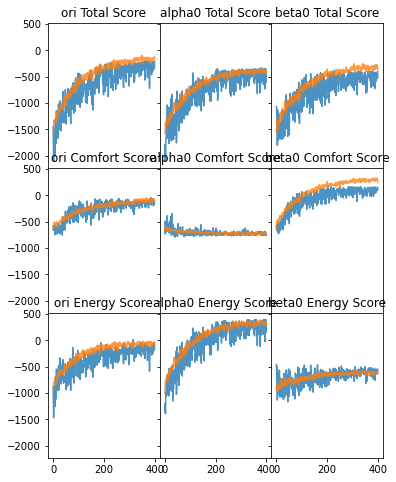

In [13]:
#plt.figure(figsize=(8, 6))
type = "ori"
fig, axes = plt.subplots(3, 3, figsize=(6,8), sharex=True, sharey=True)
for i, type in enumerate(["ori", "alpha0", "beta0"]):
    cen = np.array(centralized_convergence_plots[type])
    decen = np.array(decentralized_convergence_plots[type])
    for j, score_method in enumerate(['Total Score', 'Comfort Score', 'Energy Score']):
        curr_cen = cen[:, j]
        curr_decen = decen[:, j]
        axes[j, i].plot(curr_cen, label=f'Centralized', alpha=0.8)
        axes[j, i].plot(curr_decen, label=f'distributed', alpha=0.8)
        axes[j, i].set_title(type + " " + score_method)

fig.subplots_adjust(hspace=0, wspace=0)
plt.show()

In [14]:
# centralized policy

In [15]:
rl_model = pkl.load(open(f"{path_folder}/centralized_control_ori_model.pkl", "rb"))
if online_test:
    sim = CentralizedAggregatedSim(Simulator(interval=30)) 
else:
    sim = CentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))
    
sim.step()
centralized_temp_contorls = []
recorded_states = []
actions = []

centralized_rewards = []

for i in range(19):
    state = sim.get_states()
    reward = sim.get_reward()

    total_score, comfort_score, energy_score = sim.get_score()
    centralized_rewards.append(total_score)
    recorded_states.append(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = rl_model.predict(state)
    rl_temp = action_space.convert(action.item())
    actions.append(rl_temp)
    centralized_temp_contorls.append(rl_temp)
    sim.apply_action(rl_temp)
    sim.step()

100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


Error: cannot extract from n ### The group of Families with Young Children prefer stores that offer products and services suitable for their children's needs and comfort. They also prefer stores that provide a warmer environment for their children.###!


100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


Error: cannot extract from n ### The percentages are subjective and may vary depending on individual preferences.###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!


100%|██████████| 11/11 [00:05<00:00,  2.05it/s]


Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences.###!


100%|██████████| 11/11 [00:06<00:00,  1.66it/s]


Error: cannot extract from n ### Percentiles are subjective and may vary based on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:07<00:00,  1.40it/s]


In [16]:
# decentralized
rl_models = pkl.load(open(f"{path_folder}/decentralized_control_ori_model.pkl", "rb"))

In [17]:
if online_test:
    sim = DecentralizedAggregatedSim(Simulator(interval=30)) 
else:
    sim = DecentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))
sim.step()
decentralized_temp_contorls = []
actions = []

decentralized_rewards = []

for i in range(19):
    actions_list = []
    actions_tensor = []
    store_names, state_mat = sim.get_states()
    states = []
    for state in state_mat:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        states.append(state)

    for state, model in zip(states, rl_models):
        action = model.predict(state)
        rl_temp = action_space.convert(action.item())
        actions_list.append(rl_temp)
        actions_tensor.append(action)
    
    decentralized_temp_contorls.append(actions_list)
    sim.apply_action(actions_list)
    sim.step()
    store_names, next_state_mat = sim.get_states()
    next_rewards = sim.get_rewards()

    score, comfort_score, energy_score = sim.get_score()
    decentralized_rewards.append(score)
    
    next_states = []
    for action, state, next_state, next_reward, model in zip(actions_tensor, states, next_state_mat, next_rewards, rl_models):
        next_state = model.step(action, state, next_state, next_reward)
        next_states.append(next_state)
    states = next_states    

100%|██████████| 11/11 [00:06<00:00,  1.80it/s]


Error: cannot extract from n ### The percentages are subjective and may vary based on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:08<00:00,  1.31it/s]


Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:05<00:00,  1.96it/s]


Error: cannot extract from n ### The percentages are subjective and may vary depending on individual preferences.###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!
Error: cannot extract from n ### 2.5###!


100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


Error: cannot extract from n ### Percentiles are subjective and may vary based on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:05<00:00,  2.06it/s]


In [18]:
#import numpy as np
#import pandas as pd
#recorded_states = np.array(recorded_states)
#recorded_pops, times = recorded_states[:, :-2].T, recorded_states[:, -1]
#df = pd.DataFrame(recorded_pops, columns=times)
#pop_types = sim.rst_df.columns.tolist()[1:-2]
#df.index = pop_types

#import seaborn as sns
#sns.set(rc={'figure.figsize':(10, 5)})
#sns.heatmap(df, annot=True, cmap="afmhot", fmt=".0f")
#plt.show()
#sns.lineplot(times, decentralized_temp_contorls)
#plt.show()
#sns.lineplot(times, decentralized_rewards)
#plt.show()

# set point

In [19]:
SET_POINT = 25
# centralized


rl_model = pkl.load(open(f"{path_folder}/centralized_control_ori_model.pkl", "rb"))
if online_test:
    sim = CentralizedAggregatedSim(Simulator(interval=30))
else:
    sim = CentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))
    
sim.step()
set_point_temp_contorls = []
recorded_states = []
actions = []

set_point_rewards = []
for i in range(19):
    state = sim.get_states()
    reward = sim.get_reward()

    score, comfort_score, energy_score= sim.get_score()
    set_point_rewards.append(score)
    recorded_states.append(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = rl_model.predict(state)
    #action = rl_model.select_action(state)
    rl_temp = SET_POINT
    actions.append(rl_temp)
    set_point_temp_contorls.append(rl_temp)
    sim.apply_action(rl_temp)
    sim.step()

100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences.###!


100%|██████████| 11/11 [00:04<00:00,  2.25it/s]


Error: cannot extract from n ### Percentiles are subjective and may vary based on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


In [20]:
rl_model = pkl.load(open(f"{path_folder}/centralized_control_beta0_model.pkl", "rb"))

if online_test:
    sim = CentralizedAggregatedSim(Simulator(interval=30))
else:
    sim = CentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))

sim.step()
centralized_temp_contorls_beta0 = []
recorded_states = []
actions = []

centralized_rewards = []

for i in range(19):
    state = sim.get_states()
    reward = sim.get_reward()

    total_score, comfort_score, energy_score = sim.get_score()
    centralized_rewards.append(total_score)
    recorded_states.append(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = rl_model.predict(state)
    rl_temp = action_space.convert(action.item())
    actions.append(rl_temp)
    centralized_temp_contorls_beta0.append(rl_temp)
    sim.apply_action(rl_temp)
    sim.step()


rl_model = pkl.load(open(f"{path_folder}/centralized_control_alpha0_model.pkl", "rb"))
if online_test:
    sim = CentralizedAggregatedSim(Simulator(interval=30))
else:
    sim = CentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))
sim.step()
centralized_temp_contorls_alpha0 = []
recorded_states = []
actions = []

centralized_rewards = []

for i in range(19):
    state = sim.get_states()
    reward = sim.get_reward()

    total_score, comfort_score, energy_score = sim.get_score()
    centralized_rewards.append(total_score)
    recorded_states.append(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = rl_model.predict(state)
    rl_temp = action_space.convert(action.item())
    actions.append(rl_temp)
    centralized_temp_contorls_alpha0.append(rl_temp)
    sim.apply_action(rl_temp)
    sim.step()

100%|██████████| 11/11 [00:06<00:00,  1.81it/s]


Error: cannot extract from n ### Percentiles are subjective and may vary depending on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:08<00:00,  1.24it/s]


Error: cannot extract from n ### The percentages are subjective and may vary depending on individual preferences.###!


100%|██████████| 11/11 [00:05<00:00,  1.86it/s]


Error: cannot extract from n ### The distribution is based on the thermal preference of families with young children who prefer warmer areas of the mall for their children's comfort. The stores that offer products and services suitable for families with young children are given a higher percentile, while those that are not a priority for them are given a lower percentile.###!


100%|██████████| 11/11 [00:05<00:00,  1.95it/s]


Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences.###!


100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


Error: cannot extract from n ### Percentiles are subjective and may vary based on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:06<00:00,  1.83it/s]


Error: cannot extract from n ### The percentages are subjective and may vary depending on individual preferences.###!


100%|██████████| 11/11 [00:06<00:00,  1.71it/s]


Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:07<00:00,  1.54it/s]


Error: cannot extract from n ### The percentiles are subjective and based on the given description of the group's preferences and interests.###!
Error: cannot extract from n ### Percentiles are estimates and may vary depending on individual preferences and circumstances.###!


100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


Error: cannot extract from n ### Percentiles are approximate and may vary based on individual preferences and needs.###!


100%|██████████| 11/11 [00:06<00:00,  1.73it/s]


Error: cannot extract from n ### The percentages are subjective and may vary depending on individual preferences.###!


100%|██████████| 11/11 [00:04<00:00,  2.37it/s]


In [21]:
sns.reset_orig()

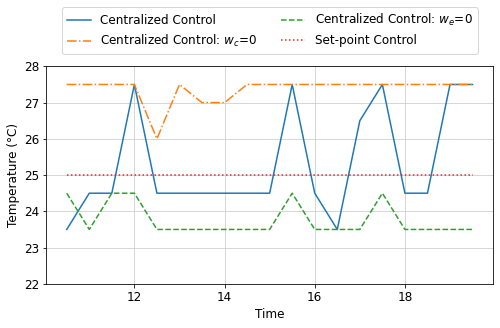

In [22]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8, 4))

plt.plot(times, centralized_temp_contorls, '-')
plt.plot(times, centralized_temp_contorls_alpha0, '-.')
plt.plot(times, centralized_temp_contorls_beta0, '--')

plt.plot(times, set_point_temp_contorls, ':')
plt.legend(['Centralized Control', 
            r'Centralized Control: $w_{c}$=0', 
            r'Centralized Control: $w_{e}$=0' ,
            'Set-point Control'], loc='upper center', fontsize=12, ncol=2, bbox_to_anchor=(0.5, 1.3))
plt.ylim([22, 28])
plt.grid(color='0.8')
plt.xlabel('Time', fontsize=12)
plt.ylabel(r'Temperature (°C)', fontsize=12)
plt.show()

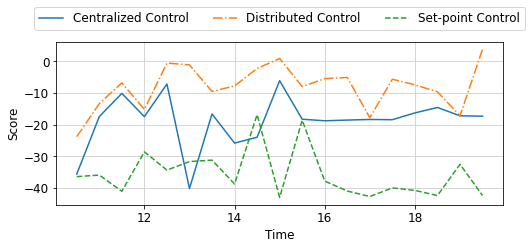

In [23]:
plt.figure(figsize=(8, 3))
plt.plot(times, centralized_rewards, '-')
plt.plot(times, decentralized_rewards, '-.')
plt.plot(times, set_point_rewards, '--')
plt.legend(['Centralized Control', 'Distributed Control', 'Set-point Control'], 
           loc='upper center', fontsize=12, ncol=3, bbox_to_anchor=(0.5, 1.25))

plt.grid(color='0.8')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, '10.5'),
  Text(1.5, 0, '11.0'),
  Text(2.5, 0, '11.5'),
  Text(3.5, 0, '12.0'),
  Text(4.5, 0, '12.5'),
  Text(5.5, 0, '13.0'),
  Text(6.5, 0, '13.5'),
  Text(7.5, 0, '14.0'),
  Text(8.5, 0, '14.5'),
  Text(9.5, 0, '15.0'),
  Text(10.5, 0, '15.5'),
  Text(11.5, 0, '16.0'),
  Text(12.5, 0, '16.5'),
  Text(13.5, 0, '17.0'),
  Text(14.5, 0, '17.5'),
  Text(15.5, 0, '18.0'),
  Text(16.5, 0, '18.5'),
  Text(17.5, 0, '19.0'),
  Text(18.5, 0, '19.5')])

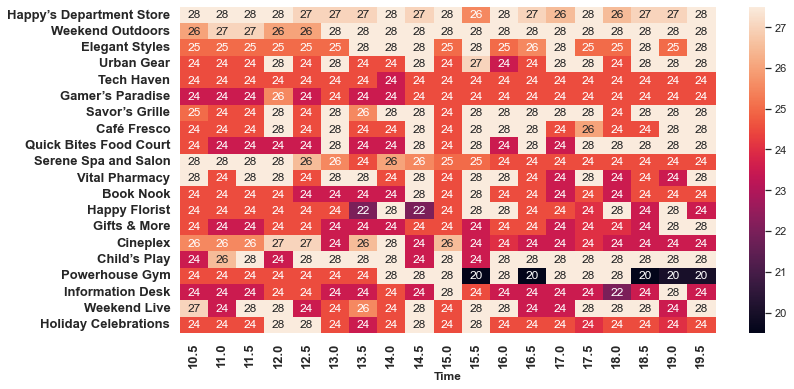

In [24]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})
df = pd.DataFrame(decentralized_temp_contorls, columns=store_names)
df.index = times
sns.heatmap(df.T, annot=True)
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold', rotation=90)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, '10.5'),
  Text(1.5, 0, '11.0'),
  Text(2.5, 0, '11.5'),
  Text(3.5, 0, '12.0'),
  Text(4.5, 0, '12.5'),
  Text(5.5, 0, '13.0'),
  Text(6.5, 0, '13.5'),
  Text(7.5, 0, '14.0'),
  Text(8.5, 0, '14.5'),
  Text(9.5, 0, '15.0'),
  Text(10.5, 0, '15.5'),
  Text(11.5, 0, '16.0'),
  Text(12.5, 0, '16.5'),
  Text(13.5, 0, '17.0'),
  Text(14.5, 0, '17.5'),
  Text(15.5, 0, '18.0'),
  Text(16.5, 0, '18.5'),
  Text(17.5, 0, '19.0'),
  Text(18.5, 0, '19.5')])

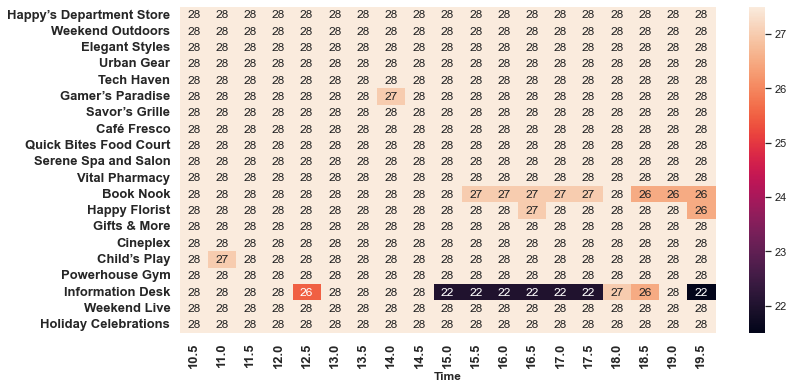

In [25]:
# decentralized
rl_models = pkl.load(open(f"{path_folder}/decentralized_control_alpha0_model.pkl", "rb"))

sim = DecentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))
sim.step()
decentralized_temp_contorls = []
actions = []

decentralized_rewards = []

for i in range(19):
    actions_list = []
    actions_tensor = []
    store_names, state_mat = sim.get_states()
    states = []
    for state in state_mat:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        states.append(state)

    for state, model in zip(states, rl_models):
        action = model.predict(state)
        rl_temp = action_space.convert(action.item())
        actions_list.append(rl_temp)
        actions_tensor.append(action)
    
    decentralized_temp_contorls.append(actions_list)
    sim.apply_action(actions_list)
    sim.step()
    store_names, next_state_mat = sim.get_states()
    next_rewards = sim.get_rewards()

    score, comfort_score, energy_score = sim.get_score()
    decentralized_rewards.append(score)
    
    next_states = []
    for action, state, next_state, next_reward, model in zip(actions_tensor, states, next_state_mat, next_rewards, rl_models):
        next_state = model.step(action, state, next_state, next_reward)
        next_states.append(next_state)
    states = next_states

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})
df = pd.DataFrame(decentralized_temp_contorls, columns=store_names)
df.index = times
sns.heatmap(df.T, annot=True)
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold', rotation=90)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5]),
 [Text(0.5, 0, '10.5'),
  Text(1.5, 0, '11.0'),
  Text(2.5, 0, '11.5'),
  Text(3.5, 0, '12.0'),
  Text(4.5, 0, '12.5'),
  Text(5.5, 0, '13.0'),
  Text(6.5, 0, '13.5'),
  Text(7.5, 0, '14.0'),
  Text(8.5, 0, '14.5'),
  Text(9.5, 0, '15.0'),
  Text(10.5, 0, '15.5'),
  Text(11.5, 0, '16.0'),
  Text(12.5, 0, '16.5'),
  Text(13.5, 0, '17.0'),
  Text(14.5, 0, '17.5'),
  Text(15.5, 0, '18.0'),
  Text(16.5, 0, '18.5'),
  Text(17.5, 0, '19.0'),
  Text(18.5, 0, '19.5')])

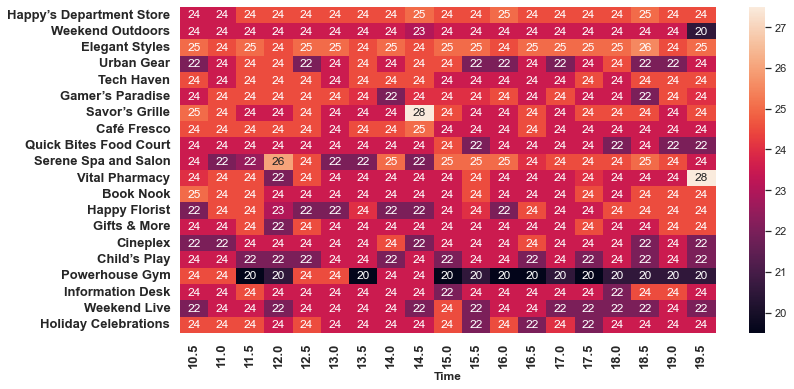

In [26]:
# decentralized
rl_models = pkl.load(open(f"{path_folder}/decentralized_control_beta0_model.pkl", "rb"))

sim = DecentralizedAggregatedSim(FastSimulator(interval=30, suffix='quicktest1'))
sim.step()
decentralized_temp_contorls = []
actions = []

decentralized_rewards = []

for i in range(19):
    actions_list = []
    actions_tensor = []
    store_names, state_mat = sim.get_states()
    states = []
    for state in state_mat:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        states.append(state)

    for state, model in zip(states, rl_models):
        action = model.predict(state)
        rl_temp = action_space.convert(action.item())
        actions_list.append(rl_temp)
        actions_tensor.append(action)
    
    decentralized_temp_contorls.append(actions_list)
    sim.apply_action(actions_list)
    sim.step()
    store_names, next_state_mat = sim.get_states()
    next_rewards = sim.get_rewards()

    score, comfort_score, energy_score = sim.get_score()
    decentralized_rewards.append(score)
    
    next_states = []
    for action, state, next_state, next_reward, model in zip(actions_tensor, states, next_state_mat, next_rewards, rl_models):
        next_state = model.step(action, state, next_state, next_reward)
        next_states.append(next_state)
    states = next_states

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 6)})
df = pd.DataFrame(decentralized_temp_contorls, columns=store_names)
df.index = times
sns.heatmap(df.T, annot=True)
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold', rotation=90)